# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
#import matplotlib
#matplotlib.use('GTKAgg') 
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $CO$

In [3]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
naSmall = [16,64,96,160]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
reload(LR)
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [5]:
nalphaEmax = {}
rVals = CO.keys()
rVals.sort()
eMax = CO[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(CO[rVals[-1]]['logfile'].evals[0][0])-norbCO
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= CO[r]['logfile'].evals[0][0][norbCO+na]
    nalphaEmax[r] = na
nalphaEmax

max sampled energy =  14.7769179033


{7.0: 98, 9.0: 185, 10.0: 280}

In [6]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:280,9.0:280,10.0:280}
nalphaEmax

{7.0: 98, 9.0: 185, 10.0: 280}

In [7]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall,nalphaEmax)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 185
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 98


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [8]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [9]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

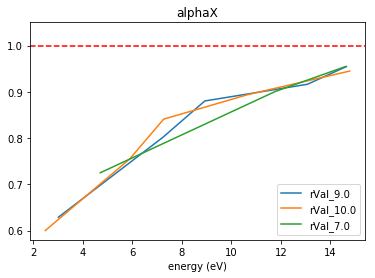

In [10]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [11]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  185
numpoint =  316  omegaMax (eV) =  43.0272129952
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  98
numpoint =  316  omegaMax (eV) =  43.0968827189


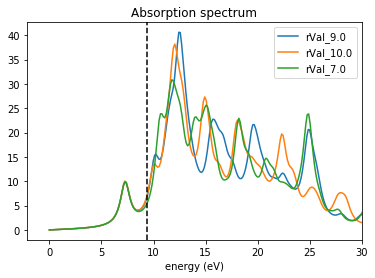

In [12]:
%matplotlib inline
syst = CO_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [13]:
print HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO))
th_value = 1e-4
th_levels = [1,2,3,3,4]

[ 27.65494303  14.24083585  11.117007    11.11700672   9.36639558]


In [14]:
reload(LR)
numExc = 900
LR.collect_excitation_thr(CO,norbCO,numExc,th_levels,th_value)
CO_channels = LR.collect_channels(CO,norbCO,numExc,th_levels)

We plot the excitations landscape in the different box

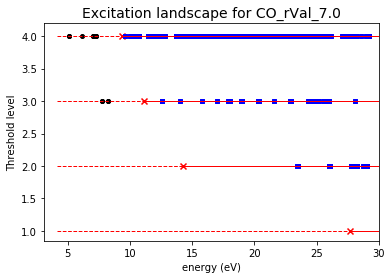

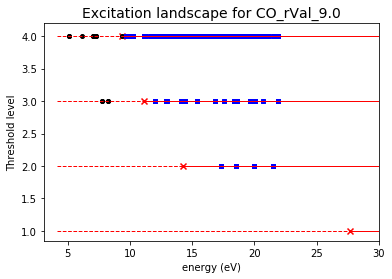

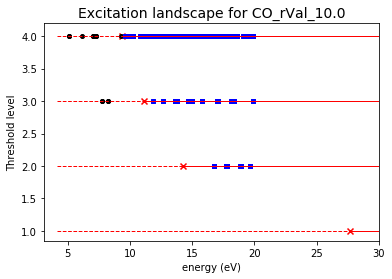

In [15]:
rVal = CO.keys()
rVal.sort()
for r in rVal:
    nalpha = CO[r]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[r]['eigenproblems'][nvirt]
    th_energies = HaeV*abs(LR.get_p_energy(CO[r]['logfile'],norbCO))

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
    Emax = 30 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for level in CO_channels[r]:
        eng_th = th_energies[th_levels.index(level)]
        plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
        plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
        plt.scatter(eng_th,level,marker='x',c='red')
  
        for exc in CO_channels[r][level]:
            if exc[1] < eng_th: 
                plt.scatter(exc[1],level,s=16,marker='o',c='black')
            else:
                plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
    plt.title('Excitation landscape for CO_rVal_'+str(r),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos of each channel comparing the results of different box

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


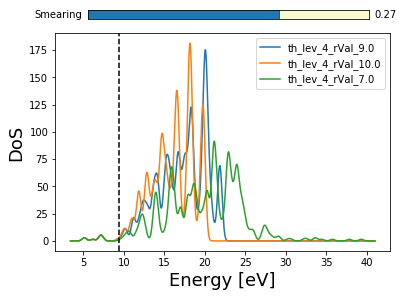

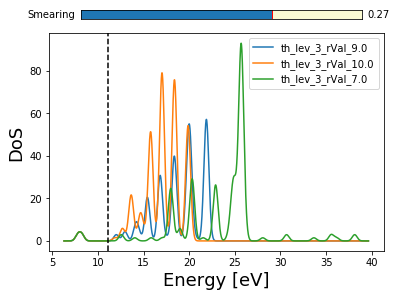

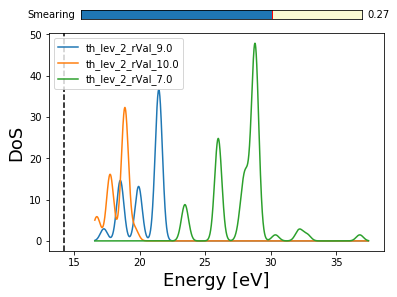

In [16]:
%matplotlib inline
levels = [4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[th_levels.index(l)])
    dos=D.DoS(fermi_level=fe)
    for rVal in CO_channels:
        eng = []
        for exc in CO_channels[rVal][l]:
            eng.append(exc[1])
        dos.append(energies=np.array([eng]),label='th_lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

Now we identify the excitations below threshold

In [17]:
reload(LR)
bt,at = LR.collect_index_bt_at(CO)

Plot the Dos below threshold

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


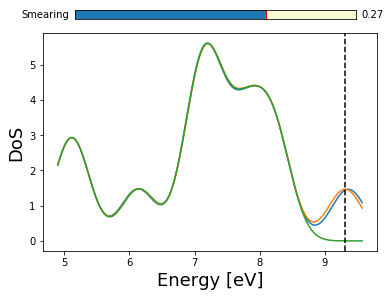

In [18]:
dos=D.DoS(fermi_level=9.3)
for rVal in CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.01*HaeV)

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [63]:
reload(LR)
CO_spectrum_bt,CO_spectrum_at = LR.collect_spectrum_bt_at(CO)

numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  160  omegaMax (eV) =  21.8861126193
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  289  omegaMax (eV) =  39.3968120121
numpoint =  289  omegaMax (eV) =  39.3968120121


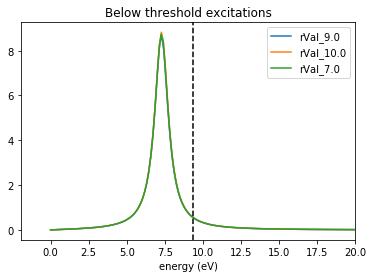

In [64]:
%matplotlib inline
syst = CO_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

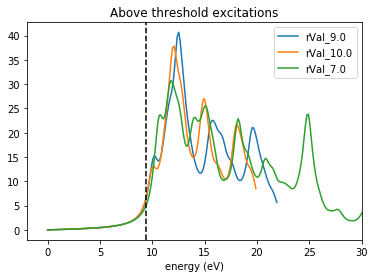

In [65]:
%matplotlib inline
syst = CO_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

## Analysis of $C_6H_6$

In [19]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
naSmall = [16,64,96,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [20]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [21]:
nalphaEmax = {}
rVals = C6H6.keys()
rVals.sort()
eMax = C6H6[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(C6H6[rVals[-1]]['logfile'].evals[0][0])-norbC6H6
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= C6H6[r]['logfile'].evals[0][0][norbC6H6+na]
    nalphaEmax[r] = na
    print 'em for ', r, ' = ', HaeV*em
nalphaEmax

max sampled energy =  9.71397014577
em for  9.0  =  9.84432534394
em for  7.0  =  9.74159044136


{7.0: 94, 9.0: 169, 10.0: 220}

In [22]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:220,9.0:220,10.0:220}
nalphaEmax

{7.0: 94, 9.0: 169, 10.0: 220}

In [23]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall,nalphaEmax)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 169
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 94


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [24]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [25]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

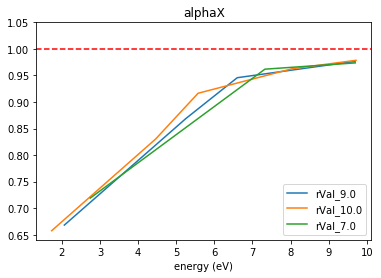

In [26]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [27]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  169
numpoint =  227  omegaMax (eV) =  31.0166062508
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  94
numpoint =  228  omegaMax (eV) =  31.09085985


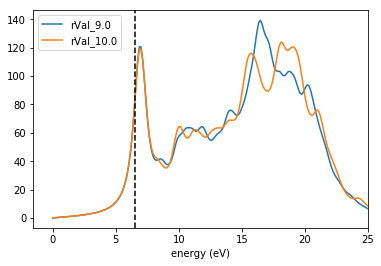

In [28]:
%matplotlib inline
syst = C6H6_spectrum
for rVal in [9.0,10.0]:#syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=25)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [74]:
print HaeV*abs(LR.get_p_energy(C6H6[10.0]['logfile'],norbC6H6))
th_value = 5e-2 # best result for 5e-2
th_levels = [1,2,2,3,3,4,5,5,6,6,7,8,8,9,9]

[ 21.15922984  18.36439554  18.36376565  14.82142626  14.82100924
  13.00017164  11.14572656  11.06283511  10.28699872  10.2864815
   9.24529617   8.28996563   8.288049     6.50839935   6.50820332]


In [75]:
reload(LR)
numExc = 1000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,th_levels,th_value)
C6H6_channels = LR.collect_channels(C6H6,norbC6H6,numExc,th_levels)

We plot the excitations landscape in the different box

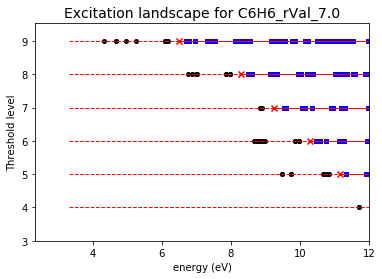

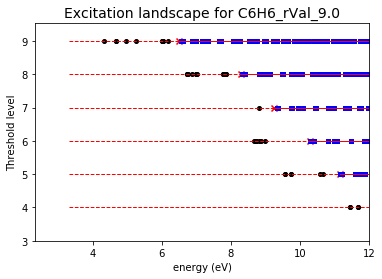

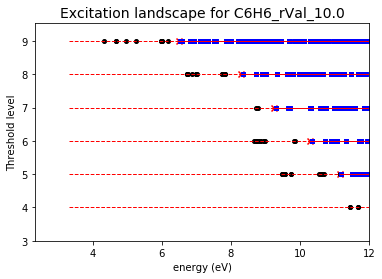

In [76]:
rVal = C6H6.keys()
rVal.sort()
for r in rVal:
    nalpha = C6H6[r]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = C6H6[r]['eigenproblems'][nvirt]
    th_energies = HaeV*abs(LR.get_p_energy(C6H6[r]['logfile'],norbC6H6))

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
    Emax = 12 #HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for level in C6H6_channels[r]:
        eng_th = th_energies[th_levels.index(level)]
        plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
        plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
        plt.scatter(eng_th,level,marker='x',c='red')
  
        for exc in C6H6_channels[r][level]:
            if exc[1] < eng_th: 
                plt.scatter(exc[1],level,s=16,marker='o',c='black')
            else:
                plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
    plt.title('Excitation landscape for C6H6_rVal_'+str(r),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.ylim(ymin=3)
    plt.show()

We plot the dos of each channel comparing the results of different box

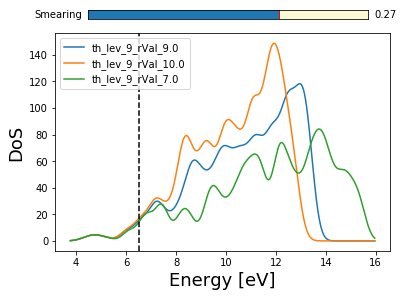

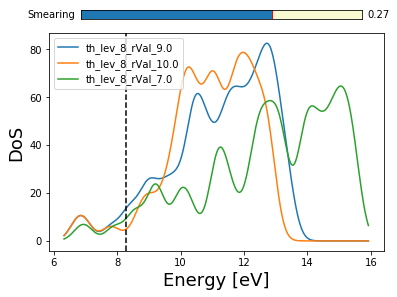

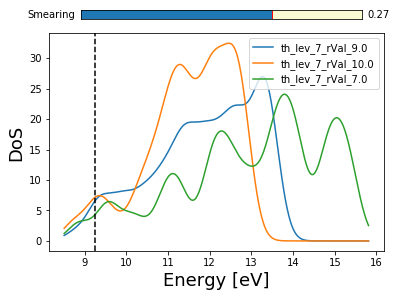

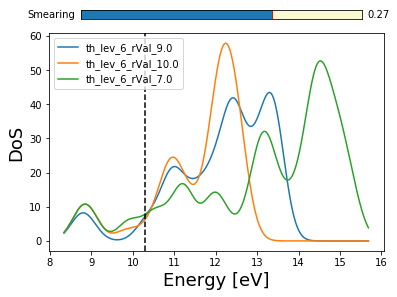

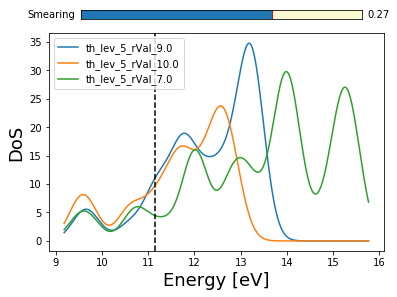

In [88]:
%matplotlib inline
levels = [9,8,7,6,5]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[th_levels.index(l)])
    dos=D.DoS(fermi_level=fe)
    for rVal in C6H6_channels:
        eng = []
        for exc in C6H6_channels[rVal][l]:
            eng.append(exc[1])
        dos.append(energies=np.array([eng]),label='th_lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

Now we identify the excitations below threshold

In [78]:
reload(LR)
bt,at = LR.collect_index_bt_at(C6H6)

Plot the Dos below threshold

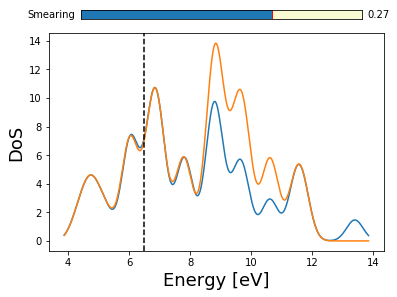

In [83]:
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.01*HaeV)

Plot the dos above threshold

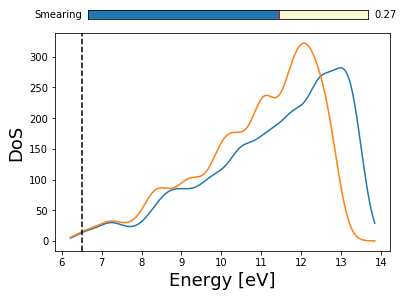

In [84]:
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.01*HaeV)

Plot the complete dos

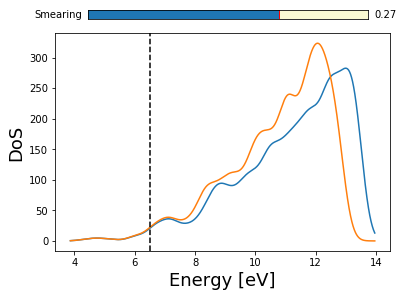

In [80]:
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]: #C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][at[rVal]+bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.01*HaeV)

In [ ]:
################################################################

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [84]:
reload(LR)
numExc = 1000 #2000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,tol=1e-1)

In [86]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    maxEng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  13.5074761597
maxEng for rval_ 10.0  =  12.8450322156
maxEng for rval_ 7.0  =  15.4923605166


We plot the excitations landscape in the different box

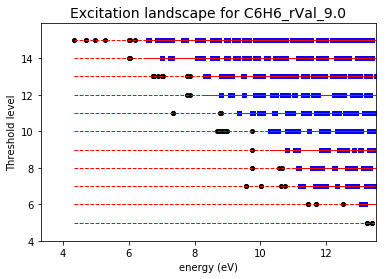

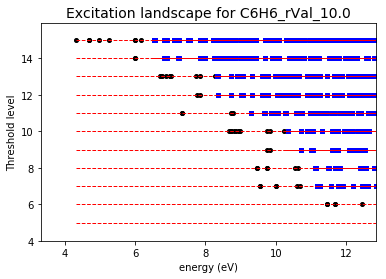

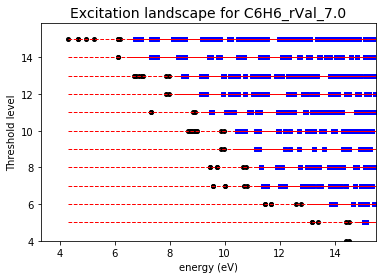

In [87]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = C6H6[rVal]['eigenproblems'][nvirt]
    pEng = LR.get_p_energy(C6H6[rVal]['logfile'],norbC6H6)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for C6H6_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.ylim(ymin=4)
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [88]:
reload(LR)
channels = LR.collect_channels(C6H6,norbC6H6,numExc)

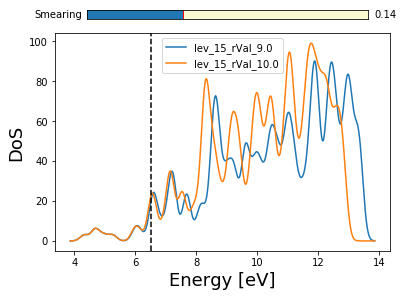

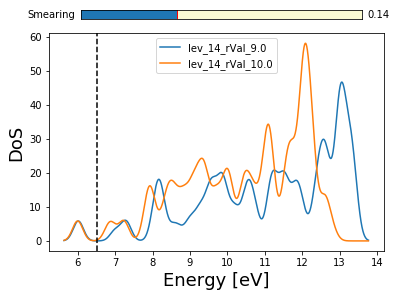

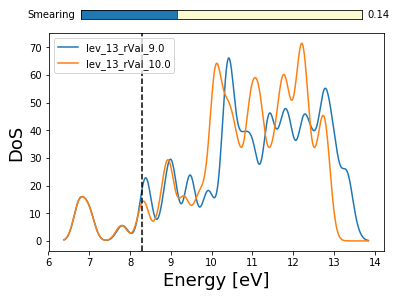

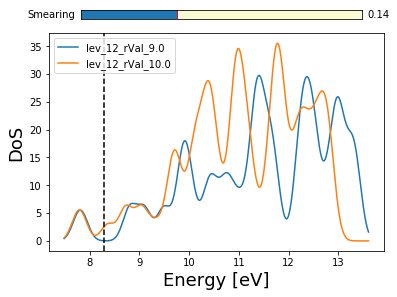

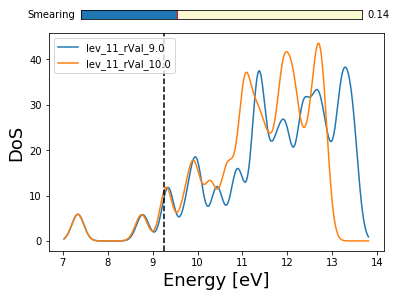

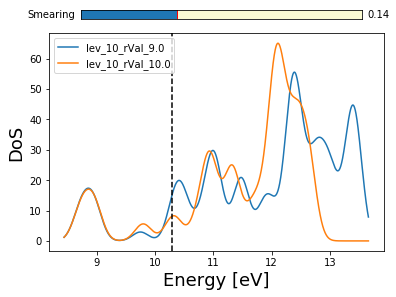

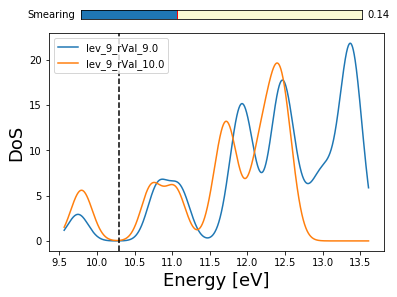

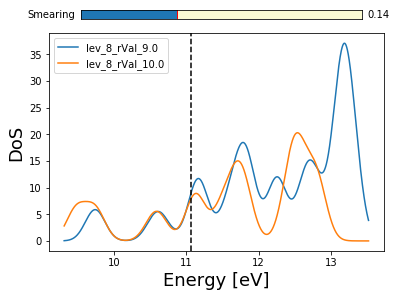

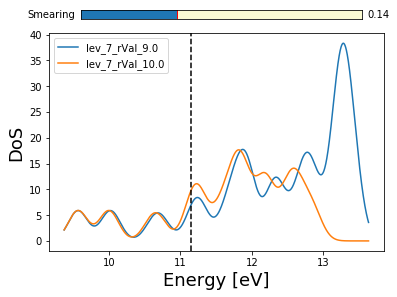

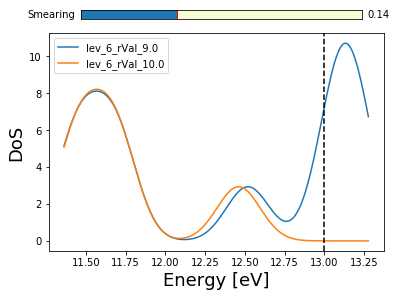

In [96]:
%matplotlib inline
levels = [15,14,13,12,11,10,9,8,7,6]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in [9.0,10.0]: #channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.005*HaeV)

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [92]:
reload(LR)
C6H6_spectrum_bt,C6H6_spectrum_at = LR.collect_spectrum_bt_at(C6H6)

numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  113  omegaMax (eV) =  15.4923605166
numpoint =  113  omegaMax (eV) =  15.4923605166


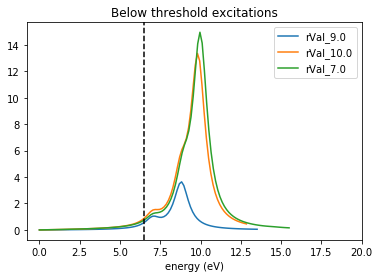

In [93]:
syst = C6H6_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

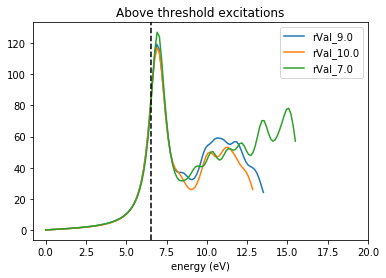

In [94]:
%matplotlib inline
syst = C6H6_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

In [95]:
rVal= 7.0
syst = C6H6[rVal]['eigenproblems']
nalpha = syst.keys()
nalpha.sort()
nvirt = nalpha[-1]

for exc in range(50):

    pProj = LR.identify_contributions(norbC6H6,nvirt,exc,syst[nvirt]['eigenvectors'])
    out = pProj[0:norbC6H6] + pProj[norbC6H6:2*norbC6H6]
    for ind,o in enumerate(out):
        if o<1e-2: 
            out[ind] = 0.0
    som = 0
    for o in out: som+=o
    print out, som, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc]),syst[nvirt]['oscillator_strength_avg'][exc] 

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49712525  0.49740396] 0.99452920596 4.32413319159 6.73104214945e-32
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49964347  0.49989431] 0.999537778037 4.68670603141 1.863713873e-30
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49944749  0.50008986] 0.999537351821 4.68672468612 8.7740499286e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.50054022  0.49936975] 0.999909965671 4.9653974086 3.98111204512e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0

In [ ]:
def extractEigenProblems(box,np_small):
    """
    Build the dictionary with the solutions of the eigenproblems for each choice of na
    We perform the transpose of the matrix with eigenvectors to have them sorted as row vectors
    """
    return partial_eigenp([np_small],[box['nvirt']],box['C'],box['T'],[box['nvirt']])